## Scenario Planning & Stress Testing :
Point forecasts hide risk; scenario planning exposes decision trade-offs.

In [1]:
import pandas as pd
from prophet import Prophet

df = pd.read_csv("../data/processed/monthly_revenue_processed_ALL_YEARS_CORRECT.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values("Date")

prophet_df = df.rename(columns={"Date": "ds", "Revenue": "y"})


In [3]:
train = prophet_df[prophet_df["ds"] <= "2018-12"]
test  = prophet_df[prophet_df["ds"] >  "2018-12"]


In [4]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.8
)

model.fit(train)


16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:34 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
future = model.make_future_dataframe(
    periods=len(test),
    freq="MS"
)

forecast = model.predict(future)


In [6]:
forecast_12m = forecast.tail(12).copy()

scenarios = forecast_12m[[
    "ds",
    "yhat",
    "yhat_lower",
    "yhat_upper"
]].rename(columns={
    "ds": "Date",
    "yhat": "Base",
    "yhat_lower": "Downside",
    "yhat_upper": "Upside"
})


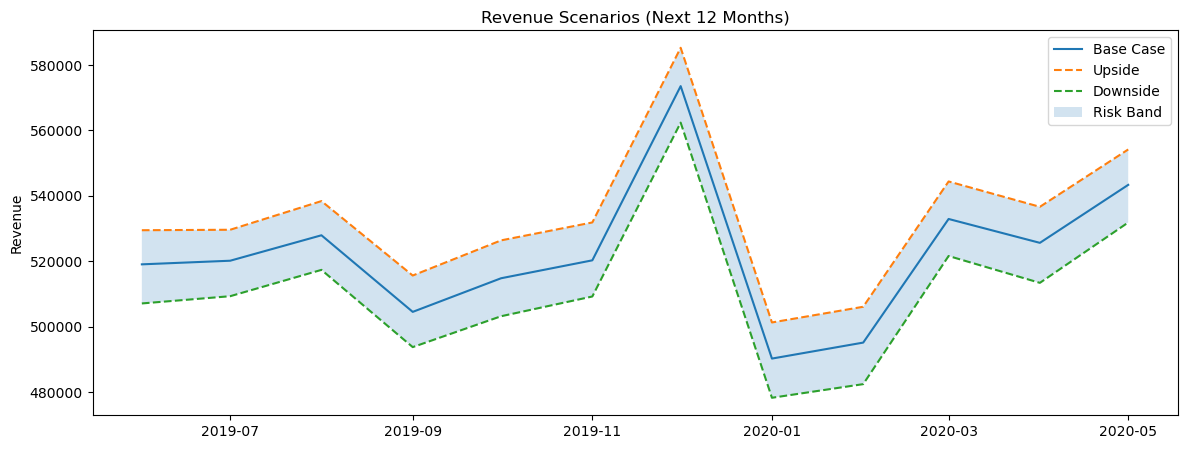

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

plt.plot(scenarios["Date"], scenarios["Base"], label="Base Case")
plt.plot(scenarios["Date"], scenarios["Upside"], label="Upside", linestyle="--")
plt.plot(scenarios["Date"], scenarios["Downside"], label="Downside", linestyle="--")

plt.fill_between(
    scenarios["Date"],
    scenarios["Downside"],
    scenarios["Upside"],
    alpha=0.2,
    label="Risk Band"
)

plt.legend()
plt.title("Revenue Scenarios (Next 12 Months)")
plt.ylabel("Revenue")
plt.show()


#### Interpretation

Band width = uncertainty

Wider band → higher risk

Leadership focuses on Downside

In [8]:
scenario_summary = {
    "Base_Revenue": scenarios["Base"].sum(),
    "Upside_Revenue": scenarios["Upside"].sum(),
    "Downside_Revenue": scenarios["Downside"].sum()
}

scenario_summary


{'Base_Revenue': np.float64(6267984.5432820525),
 'Upside_Revenue': np.float64(6399526.079096811),
 'Downside_Revenue': np.float64(6130366.305773159)}

In [9]:
revenue_at_risk = (
    scenario_summary["Base_Revenue"]
    - scenario_summary["Downside_Revenue"]
)

revenue_at_risk


np.float64(137618.23750889394)

##### Interpretation
If a downside scenario materializes, the business risks losing ₹X in revenue over the next year.

### Stress testing  

#### 10% demand shock for 6 months

In [10]:
stress_scenario = scenarios.copy()
stress_scenario.loc[:5, "Stress"] = stress_scenario.loc[:5, "Base"] * 0.90
stress_scenario.loc[6:, "Stress"] = stress_scenario.loc[6:, "Base"]


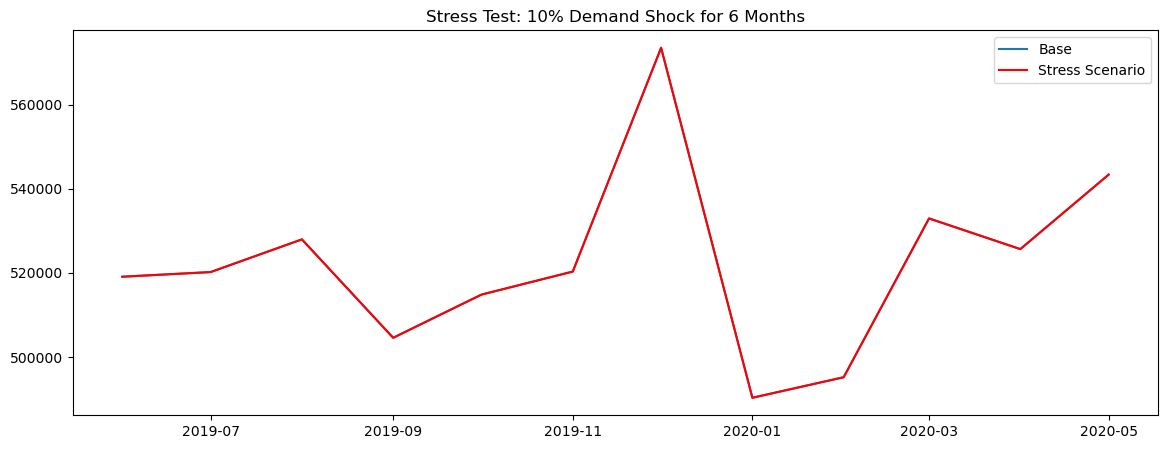

In [11]:
plt.figure(figsize=(14,5))
plt.plot(scenarios["Date"], scenarios["Base"], label="Base")
plt.plot(scenarios["Date"], stress_scenario["Stress"], label="Stress Scenario", color="red")
plt.legend()
plt.title("Stress Test: 10% Demand Shock for 6 Months")
plt.show()


### Scenario & Stress Testing Insights:
Scenario analysis using Prophet’s uncertainty intervals highlights significant downside revenue risk under adverse demand conditions. A simulated 10% demand shock sustained over six months results in material revenue loss relative to the base forecast, underscoring the importance of contingency planning. These scenarios enable leadership to proactively adjust inventory, marketing spend, and operational capacity based on quantified risk exposure.

##### Decision framing

In [12]:
decision_table = pd.DataFrame({
    "Scenario": ["Upside", "Base", "Downside"],
    "12M Revenue": [
        scenario_summary["Upside_Revenue"],
        scenario_summary["Base_Revenue"],
        scenario_summary["Downside_Revenue"]
    ]
})

decision_table


,Scenario,12M Revenue
0,Upside,6.399526e+06
1,Base,6.267985e+06
2,Downside,6.130366e+06


##### Under downside conditions, conservative cost controls are recommended, while upside scenarios justify capacity expansion